# Business Understanding



## Wie (de opdrachtgever)? 

Appbakkers (Corné & Guido) is een bedrijf die (mobiele) applicaties ontwikkeld.  


## Wat (de opdracht)? 

Bij opname van een patiënt wordt er een elektrocardiogram (ECG) gemaakt. Hierbij worden alle elektrische impulsen in het hart geregistreerd, waardoor kan worden afgeleid welke gebieden van het hart naar behoren functioneren.  

Als een ECG is gemaakt, wordt het nu door een deskundige bekeken en gelabeld. Zo kan worden gezien of de patient een cardiovasculaire ziekte heeft. Nu kost dit labelen veel tijd en zijn er niet veel deskundigen die het accuraat kunnen labelen/onderzoeken. Om het labelen ervan makkelijker te maken is er een behoefte naar een model die de categorie kan bepalen aan de hand van een ECG.

<a id='categorieën'>De categorieën waarin deze ECG's zich kunnen bevinden:</a>

N - 0
* Normal
* Left/Right bundle branch block
* Atrial escape
* Nodal escape</br>

S - 1
* Atrial premature
* Aberrant atrial premature
* Nodal premature
* Supra-ventricular premature</br>

V - 2
* Premature ventricular contraction
* Ventricular escape</br>

F - 3
* Fusion of ventricular and normal</br>

Q - 4
* Paced
* Fusion of paced and normal
* Unclassifiable


## Wanneer (tijdsframe)? 

Deze opdracht voeren we uit vanaf 13 april ’22. Op deze dag hebben we de kennismaking gehad met onze opdrachtgever. Hierin hebben we de opdracht besproken en een aantal afspraken gemaakt. De einddatum van de opdracht zal zijn op 3 juni ’22. 

## Waarom (doel)? 

Het doel is om te achterhalen of hartslag een goede voorspeller kan zijn van de calciumscore. 

Als het model gemaakt is om dit te voorspellen kan deze verbeterd/uitgebreid worden met de resultaten en de calciumscore uitkomsten of de aanwezigheid van bradycardie/tachycardie/normale hartslag (en meer specifiek het aantal hartslagen per minuut) de calciumscore kan voorspellen.  

## Wat (wat gaan we gebruiken)? 

Door middel van Jupyter notebooks gaan wij het model ontwikkelen.  

# Data Understanding

Frequentie van de ECG's: 125Hz </br>
Data bron: Physionet's MIT-BIH Arrhythmia Dataset

### "mitbih_train.csv" en "mitbih_test.csv"

* Kolom 0 t/m 186          
    Een reeks aan voltages binnen een bereik van 0 tot 1, die één hartslag omvatten, **float** <br/>
* Kolom 187         
    [De categorie waarin deze bevind](#categorieën) , **integer**<br/>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas_profiling as pp
import itertools

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

import tensorflow
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import models

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation

from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline

In [11]:
ecg1_train = pd.read_csv('Data/ECG/mitbih_train.csv',delimiter=',', header=None)
ecg1_test = pd.read_csv('Data/ECG/mitbih_test.csv',delimiter=',', header=None)
ecg_data = pd.concat([ecg1_train, ecg1_test], axis=0)
ecg_data.shape

whole_ecg = pd.read_csv('Data/ECG/ecg.csv', delimiter='\t')
whole_ecg

,samplenr,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6,measurement
0,0,180,220,40,-200,80,120,-20,380,260,160,120,160,NaN
1,1,160,200,40,-180,60,120,0,360,260,160,120,160,NaN
2,2,160,180,20,-180,60,100,-20,320,260,160,120,160,NaN
3,3,140,180,40,-160,40,100,0,300,240,140,100,140,NaN
4,4,140,180,40,-160,60,100,0,280,240,140,100,140,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,-80,-40,60,60,-60,20,60,-60,-20,20,20,-60,NaN
4996,4996,-80,-40,40,60,-60,0,60,-60,-20,20,20,-60,NaN
4997,4997,-80,-40,40,60,-60,-20,60,-60,-20,20,20,-60,NaN
4998,4998,-80,-40,60,60,-80,0,60,-60,-20,20,20,-60,NaN


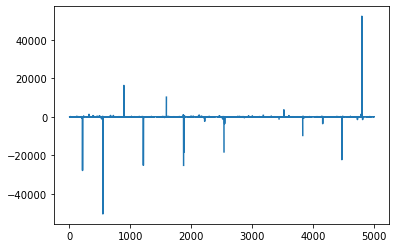

In [24]:
plt.plot((whole_ecg['II']-whole_ecg['II'].min()).pct_change().pct_change().pct_change().pct_change().pct_change())

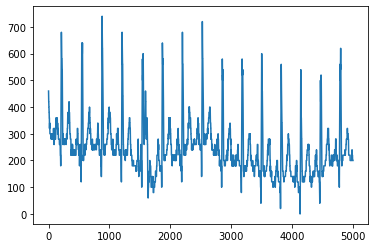

In [26]:
two = (whole_ecg['II']-whole_ecg['II'].min())
plt.plot(two)

209
336
333
328
335
328
328
327
330
324
322
321
322
334
309


[209,
 545,
 878,
 1206,
 1541,
 1869,
 2197,
 2524,
 2854,
 3178,
 3500,
 3821,
 4143,
 4477,
 4786]

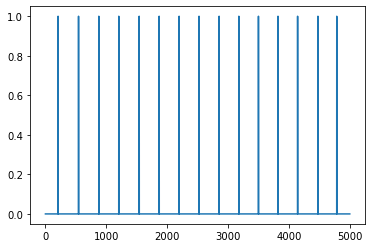

In [66]:
peak = [1 if x > 510 else 0 for x in two]
#plt.plot(peak)

counter = 0
change = []
indices = []
index = 0
for row in peak:
    index = index + 1
    counter = counter + 1
    if (row == 1):
        if (counter > 100):
            print(counter)
            counter=0
    if (counter == 0):
        change.append(1)
        indices.append(index)
    else:
        change.append(0)
        
            
np.sum(peak)


plt.plot(change)
indices

## Value Distribution

In [ ]:
ecg_data[187].value_counts()

In [ ]:
percentage = [x/len(ecg_data) for x in ecg_data[187].value_counts().sort_index()]
plt.rcParams["figure.figsize"] = (10,10)
fig = plt.pie(percentage, labels=['N','S','V','F','Q'], autopct='%1.1f%%', normalize=False)
plt.title('Percentage per category')
plt.show()

Zoals je kan zien, zijn de verschillende categorieën niet evenredig verdeeld. Om het model goed te kunnen trainen op alle categorieën, moeten we zo bij Data Preparation er voor zorgen dat elke categorie evenveel gerepresenteerd is in de data.

In [ ]:
titles = ['N','S','V','F','Q']
fig, ax = plt.subplots(3, 2, figsize=(18,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
x_label = np.arange(0, 187)*8/1000
x = 0
y = 0
for i in range(0,5):
    if (x == 2):
        y += 1
        x = 0
    current_ax = ax[y,x]
    current_ax.plot(x_label,ecg_data[ecg_data[187] == i].iloc[0][:187])
    current_ax.set_title("Een hartslag in categorie " + titles[i])
    current_ax.set_ylabel("Amplitude", fontsize=12)
    current_ax.set_xlabel("Tijd (s)", fontsize=12)
    x += 1
fig.delaxes(ax[2,1])
fig.suptitle('Een hartslag in elke categorie', fontsize=25)
plt.show()

In [ ]:
plt.plot(x_label,ecg_data.mean()[:187])
plt.title('Gemiddelde waardes voor elk punt')
plt.xlabel('Tijd (s)')
plt.ylabel('Amplitude')

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(18,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
x = 0
y = 0
for i in range(0,5):
    if (x == 2):
        y += 1
        x = 0
    current_ax = ax[y,x]
    current_ax.plot(x_label,ecg_data[ecg_data[187] == i].mean()[:187])
    current_ax.set_title("Gemiddelde in categorie " + titles[i])
    current_ax.set_ylabel("Amplitude", fontsize=12)
    current_ax.set_xlabel("Tijd (s)", fontsize=12)
    x += 1
fig.delaxes(ax[2,1])
fig.suptitle('Gemiddelde waardes in elke categorie', fontsize=25)
plt.show()

In [ ]:
plt.plot(ecg_data[:187].mean()[:187].pct_change())
plt.title('% verschil van het gemiddelde')
plt.xlabel('Tijd (s)')
plt.ylabel('Verschil in %')

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(18,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
x = 0
y = 0
for i in range(0,5):
    if (x == 2):
        y += 1
        x = 0
    current_ax = ax[y,x]
    current_ax.plot(x_label,ecg_data[ecg_data[187] == i].mean()[:187].pct_change())
    current_ax.set_title("% verschil in " + titles[i])
    current_ax.set_ylabel("Amplitude", fontsize=12)
    current_ax.set_xlabel("Tijd (s)", fontsize=12)
    x += 1
fig.delaxes(ax[2,1])
fig.suptitle('% verschil van het gemiddelde in elke categorie', fontsize=25)
plt.show()

Hieruit is op te merken dat in een slechtere categorie de waardes minder vlak zijn en meer uitschieten.

In [ ]:
def plot_histogram(category,start,end,ax):
    bins = end-start
    #x_label = np.arange(start, end)*8/1000
    
    img=ecg_data[ecg_data[187]==category].values
    img=img[:,start:end]
    y=img.flatten()
    
    x=np.arange(start,end)
    for i in range(img.shape[0]-1):
        row=np.arange(start, end)
        x=np.concatenate((x, row), axis=None)
    ax.hist2d(x, y, bins=(bins,bins), cmap=plt.cm.jet)
    ax.set_title('Category ' + str(category))
    ax.set_ylabel("Amplitude", fontsize=15)
    ax.set_xlabel("Kolom", fontsize=15)
    

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(18,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
x = 0
y = 0

params = [5,70,5,70,5,70,5,70,5,70]
for i in range(0,5):
    if (x == 2):
        y += 1
        x = 0
    plot_histogram(i,params[i*2],params[i*2+1],ax[y,x])
    #.plot(ecg1_train[ecg1_train[187] == i].iloc[2][:187])
    #ax[y,x].set_title("Waarde histogram van categorie " + titles[i])
    x += 1
fig.delaxes(ax[2,1])
fig.suptitle('Value Occurrence per Category', fontsize=25)
plt.show()

# Data Preparation

Hierbij gaan we er eerst voor zorgen dat de data bestaat uit evenveel rijen van elke categorie. De eerste manier is door te resamplen.

In [ ]:
#ecg_data = pd.get_dummies(ecg_data, columns=[187])

In [ ]:
#ecg_data = ecg_data.rename({'187_0.0':'N','187_1.0':'S','187_2.0':'V','187_3.0':'F','187_4.0':'Q'}, axis=1)

### Manier 1 Upsampling

In [ ]:
cat_1_data = ecg_data[ecg_data[187] == 0]
cat_2_data = ecg_data[ecg_data[187] == 1]
cat_3_data = ecg_data[ecg_data[187] == 2]
cat_4_data = ecg_data[ecg_data[187] == 3]
cat_5_data = ecg_data[ecg_data[187] == 4]

In [ ]:
from sklearn.utils import resample

C1 = cat_1_data.sample(n=20000,random_state=42)
C2 = resample(cat_2_data,replace=True,n_samples=20000,random_state=43)
C3 = resample(cat_3_data,replace=True,n_samples=20000,random_state=44)
C4 = resample(cat_4_data,replace=True,n_samples=20000,random_state=45)
C5 = resample(cat_5_data,replace=True,n_samples=20000,random_state=46)

In [ ]:
ecg_data_u = pd.concat([C1,C2,C3,C4,C5])
ecg_data_u[187].value_counts()

In [ ]:
values = ecg_data_u.values
ecg_train_u = values[:, :-1]
ecg_label_u = values[:, -1].astype(int)

ecg_train_u = np.expand_dims(ecg_train_u, 2)

ohe = OneHotEncoder()
ecg_label_u = ohe.fit_transform(ecg_label_u.reshape(-1,1)).todense()

data_train_u, data_test_u, label_train_u, label_test_u = train_test_split(ecg_train_u, ecg_label_u, random_state=42, test_size=0.3)

NN_data_train_u, NN_val_data_train_u, NN_label_train_u, NN_val_label_train_u = train_test_split(data_train_u, label_train_u, random_state=42, test_size=0.5)

### Manier 2 Gelijke verdeling in test data

In [ ]:
C1 = cat_1_data.sample(n=300,random_state=42)
C2 = cat_2_data.sample(n=300,random_state=43)
C3 = cat_3_data.sample(n=300,random_state=44)
C4 = cat_4_data.sample(n=300,random_state=45)
C5 = cat_5_data.sample(n=300,random_state=46)
data_test_t = pd.concat([C1,C2,C3,C4,C5])
data_train_t = pd.concat([ecg_data, data_test_t, data_test_t]).drop_duplicates(keep=False)



values = data_test_t.values
data_test_t = values[:, :-1]
label_test_t = values[:, -1].astype(int)

values = data_train_t.values
data_train_t = values[:, :-1]
label_train_t = values[:, -1].astype(int)

data_test_t = np.expand_dims(data_test_t, 2)
data_train_t = np.expand_dims(data_train_t, 2)

ohe = OneHotEncoder()
label_test_t = ohe.fit_transform(label_test_t.reshape(-1,1)).todense()
label_train_t = ohe.transform(label_train_t.reshape(-1,1)).todense()

NN_data_train_t, NN_val_data_train_t, NN_label_train_t, NN_val_label_train_t = train_test_split(data_train_t, label_train_t, random_state=42, test_size=0.5)

### Manier 3 Downsampling

In [ ]:
C1 = cat_1_data.sample(n=800,random_state=42)
C2 = cat_2_data.sample(n=800,random_state=43)
C3 = cat_3_data.sample(n=800,random_state=44)
C4 = cat_4_data.sample(n=800,random_state=45)
C5 = cat_5_data.sample(n=800,random_state=46)

In [ ]:
ecg_data_d = pd.concat([C1,C2,C3,C4,C5])
ecg_data_d[187].value_counts()

In [ ]:
values = ecg_data_d.values
ecg_train_d = values[:, :-1]
ecg_label_d = values[:, -1].astype(int)

ecg_train_d = np.expand_dims(ecg_train_d, 2)

ohe = OneHotEncoder()
ecg_label_d = ohe.fit_transform(ecg_label_d.reshape(-1,1)).todense()

data_train_d, data_test_d, label_train_d, label_test_d = train_test_split(ecg_train_d, ecg_label_d, random_state=42, test_size=0.3)

NN_data_train_d, NN_val_data_train_d, NN_label_train_d, NN_val_label_train_d = train_test_split(data_train_d, label_train_d, random_state=42, test_size=0.5)

### Normale Data

In [ ]:
values = ecg_data.values
data_n = values[:, :-1]
label_n = values[:, -1].astype(int)

data_n = np.expand_dims(data_n, 2)

ohe = OneHotEncoder()
label_n = ohe.fit_transform(label_n.reshape(-1,1)).todense()

data_train_n, data_test_n, label_train_n, label_test_n = train_test_split(data_n, label_n, random_state=42, test_size=0.3)
NN_data_train_n, NN_val_data_train_n, NN_label_train_n, NN_val_label_train_n = train_test_split(data_train_n, label_train_n, random_state=42, test_size=0.5)

In [ ]:
len(ecg_data)

# Modeling

In [93]:
def GetModel(data_shape):
    _, feature, depth = data_shape.shape
    
    inp = Input(shape=(feature, depth))
    first = Conv1D(32, 5)(inp)

    layers = Conv1D(32, 5, padding='same')(first)
    layers = Activation("relu")(layers)
    layers = Conv1D(32, 5, padding='same')(layers)
    layers = Add()([layers, first])
    layers = Activation("relu")(layers)
    layers = MaxPooling1D(5, 2)(layers)

    layers = Flatten()(layers)

    layers = Dense(32)(layers)
    layers = Activation("relu")(layers)
    layers = Dense(32)(layers)
    layers = Dense(5)(layers)
    layers = Softmax()(layers)

    model = Model(inputs=inp, outputs=layers)
    return model

def PlotHistory(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    loss_diff = np.abs(np.array(loss_values) - np.array(val_loss_values))
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.plot(epochs, loss_diff, "r", label="Difference")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    plt.clf()

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    acc_diff = np.abs(np.array(acc) - np.array(val_acc))
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.plot(epochs, acc_diff, "r", label="Difference")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [123]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def EvaluateModel(model, data_train, data_test, label_train, label_test):
    prediction = model.predict(data_test)
    prediction = prediction > 0.5
    conf_mat = confusion_matrix(label_test, prediction)
    falsePositive = conf_mat[1][0]

    print(conf_mat)
    print(str(falsePositive) + " people of the " + str(conf_mat[1].sum()) + " that have a CVD didnt get diagnosed with it")
    print("That is " + str(round(falsePositive/conf_mat.sum()*100,2)) + "% of all patients that died because of no treatment!")
    pred = model.predict(data_train)>0.5
    pred = [bool(x) for x in pred]
    acc_train = round(((pred==label_train).sum())/(len(label_train))*100, 4)
    print("Accuracy van de training data: " + str(acc_train) + "%")
    pred = model.predict(data_test)>0.5
    pred = [bool(x) for x in pred]
    acc_test = round(((pred==label_test).sum())/(len(label_test))*100, 4)
    print("Accuracy van de test data: " + str(acc_test) + "%")
    print("Verschil: " + str(round(acc_test-acc_train,2)) + "%")
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def GenerateAndTrainModel(data_train, label_train, val_data_train, val_label_train, label_test, data_test, epochs):
    model = GetModel(data_train)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(data_train, label_train, 
                    epochs=epochs, 
                    batch_size=500,verbose=2, validation_data=(val_data_train,val_label_train))
    PlotHistory(history)
    prediction = model.predict(data_train)
    cnf_matrix = confusion_matrix(label_train.argmax(axis=1), prediction.argmax(axis=1))
    
    total = cnf_matrix[0,0] + cnf_matrix[1,1] + cnf_matrix[2,2] + cnf_matrix[3,3] + cnf_matrix[4,4] 
    percent = round(total / len(label_train),3)
    print(str(percent) + "% is correct with the train data")
    print("Counts: correct = " + str(total) + " total = " + str(len(label_train)))
    
    prediction = model.predict(data_test)
    cnf_matrix = confusion_matrix(label_test.argmax(axis=1), prediction.argmax(axis=1))
    
    total = cnf_matrix[0,0] + cnf_matrix[1,1] + cnf_matrix[2,2] + cnf_matrix[3,3] + cnf_matrix[4,4] 
    percent = round(total / len(label_test),3)
    print(str(percent) + "% is correct with the test data")
    print("Counts: correct = " + str(total) + " total = " + str(len(label_test)))
    
    np.set_printoptions(precision=2)

    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix, normalize=False, classes=['N', 'S', 'V', 'F', 'Q'],
                          title='Confusion matrix, with normalization')
    plt.show()


Epoch 1/10
3/3 - 1s - loss: 1.5879 - accuracy: 0.2307 - val_loss: 1.5051 - val_accuracy: 0.3864 - 627ms/epoch - 209ms/step
Epoch 2/10
3/3 - 0s - loss: 1.4621 - accuracy: 0.4329 - val_loss: 1.3496 - val_accuracy: 0.5943 - 225ms/epoch - 75ms/step
Epoch 3/10
3/3 - 0s - loss: 1.2928 - accuracy: 0.6000 - val_loss: 1.1655 - val_accuracy: 0.6107 - 259ms/epoch - 86ms/step
Epoch 4/10
3/3 - 0s - loss: 1.1073 - accuracy: 0.6221 - val_loss: 1.0101 - val_accuracy: 0.6436 - 257ms/epoch - 86ms/step
Epoch 5/10
3/3 - 0s - loss: 0.9812 - accuracy: 0.6314 - val_loss: 0.9418 - val_accuracy: 0.6536 - 224ms/epoch - 75ms/step
Epoch 6/10
3/3 - 0s - loss: 0.9122 - accuracy: 0.6557 - val_loss: 0.9206 - val_accuracy: 0.6714 - 229ms/epoch - 76ms/step
Epoch 7/10
3/3 - 0s - loss: 0.8722 - accuracy: 0.6800 - val_loss: 0.8611 - val_accuracy: 0.6843 - 235ms/epoch - 78ms/step
Epoch 8/10
3/3 - 0s - loss: 0.8173 - accuracy: 0.6979 - val_loss: 0.8344 - val_accuracy: 0.7200 - 230ms/epoch - 77ms/step
Epoch 9/10
3/3 - 0s - l

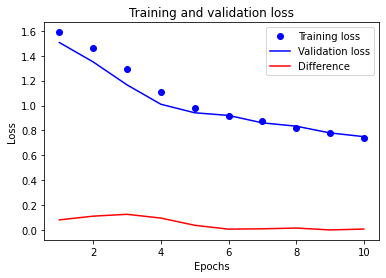

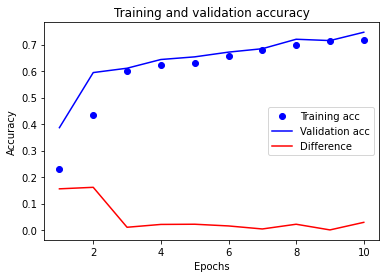

0.752% is correct with the train data
Counts: correct = 1053 total = 1400
0.712% is correct with the test data
Counts: correct = 855 total = 1200
Confusion matrix, without normalization


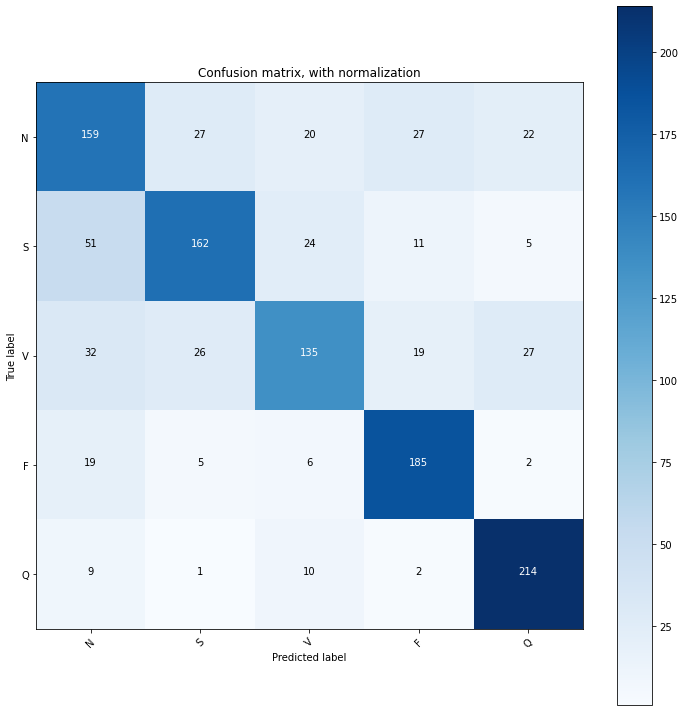

In [124]:
GenerateAndTrainModel(NN_data_train_d,NN_label_train_d,NN_val_data_train_d,NN_val_label_train_d,label_test_d,data_test_d,10)

Epoch 1/15
108/108 - 9s - loss: 0.4437 - accuracy: 0.8819 - val_loss: 0.2483 - val_accuracy: 0.9274 - 9s/epoch - 84ms/step
Epoch 2/15
108/108 - 9s - loss: 0.2134 - accuracy: 0.9383 - val_loss: 0.1868 - val_accuracy: 0.9474 - 9s/epoch - 83ms/step
Epoch 3/15
108/108 - 9s - loss: 0.1693 - accuracy: 0.9516 - val_loss: 0.1608 - val_accuracy: 0.9538 - 9s/epoch - 84ms/step
Epoch 4/15
108/108 - 9s - loss: 0.1385 - accuracy: 0.9607 - val_loss: 0.1316 - val_accuracy: 0.9645 - 9s/epoch - 80ms/step
Epoch 5/15
108/108 - 8s - loss: 0.1156 - accuracy: 0.9671 - val_loss: 0.1090 - val_accuracy: 0.9708 - 8s/epoch - 77ms/step
Epoch 6/15
108/108 - 9s - loss: 0.1000 - accuracy: 0.9721 - val_loss: 0.1041 - val_accuracy: 0.9706 - 9s/epoch - 79ms/step
Epoch 7/15
108/108 - 9s - loss: 0.0922 - accuracy: 0.9744 - val_loss: 0.0912 - val_accuracy: 0.9751 - 9s/epoch - 80ms/step
Epoch 8/15
108/108 - 8s - loss: 0.0839 - accuracy: 0.9765 - val_loss: 0.0894 - val_accuracy: 0.9745 - 8s/epoch - 78ms/step
Epoch 9/15
108/1

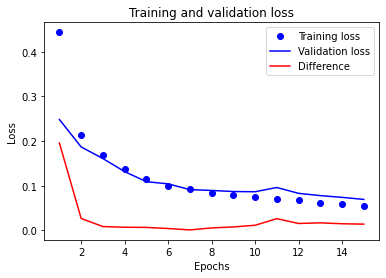

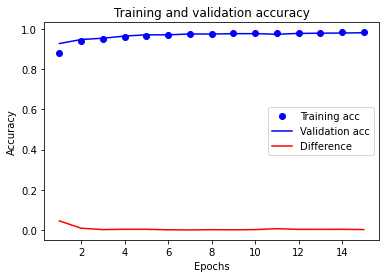

0.987% is correct with the train data
Counts: correct = 53246 total = 53973
0.837% is correct with the test data
Counts: correct = 1255 total = 1500
Confusion matrix, without normalization


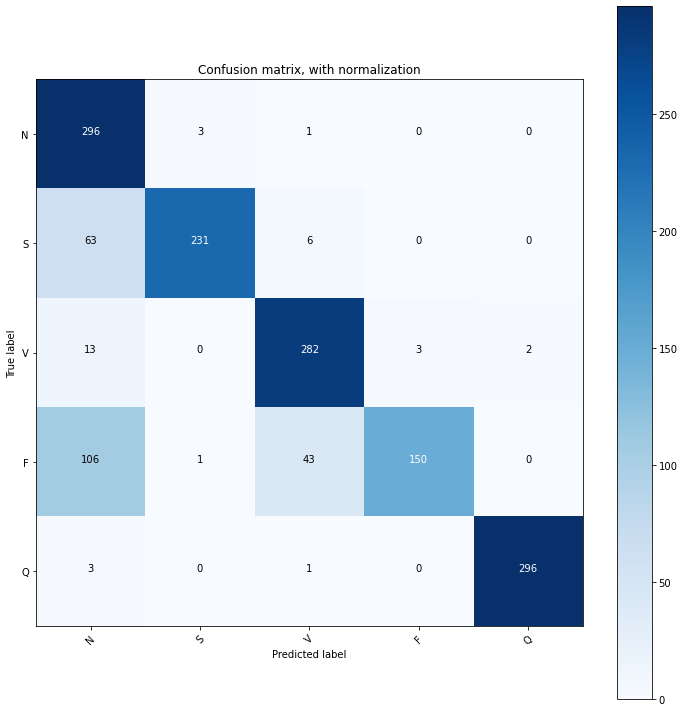

In [125]:
GenerateAndTrainModel(NN_data_train_t,NN_label_train_t,NN_val_data_train_t,NN_val_label_train_t,label_test_t,data_test_t,15)

Epoch 1/13
70/70 - 6s - loss: 0.8811 - accuracy: 0.6706 - val_loss: 0.5766 - val_accuracy: 0.7944 - 6s/epoch - 83ms/step
Epoch 2/13
70/70 - 5s - loss: 0.4628 - accuracy: 0.8357 - val_loss: 0.3994 - val_accuracy: 0.8578 - 5s/epoch - 76ms/step
Epoch 3/13
70/70 - 5s - loss: 0.3424 - accuracy: 0.8809 - val_loss: 0.3092 - val_accuracy: 0.8896 - 5s/epoch - 77ms/step
Epoch 4/13
70/70 - 5s - loss: 0.2761 - accuracy: 0.9030 - val_loss: 0.2586 - val_accuracy: 0.9072 - 5s/epoch - 77ms/step
Epoch 5/13
70/70 - 5s - loss: 0.2341 - accuracy: 0.9178 - val_loss: 0.2561 - val_accuracy: 0.9103 - 5s/epoch - 76ms/step
Epoch 6/13
70/70 - 5s - loss: 0.2080 - accuracy: 0.9273 - val_loss: 0.2068 - val_accuracy: 0.9259 - 5s/epoch - 76ms/step
Epoch 7/13
70/70 - 5s - loss: 0.1886 - accuracy: 0.9348 - val_loss: 0.1922 - val_accuracy: 0.9317 - 5s/epoch - 76ms/step
Epoch 8/13
70/70 - 5s - loss: 0.1674 - accuracy: 0.9416 - val_loss: 0.1728 - val_accuracy: 0.9407 - 5s/epoch - 77ms/step
Epoch 9/13
70/70 - 5s - loss: 0.

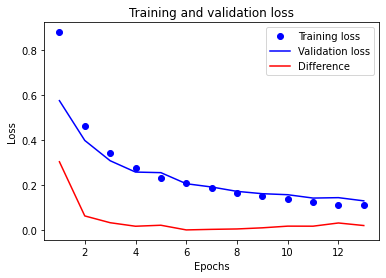

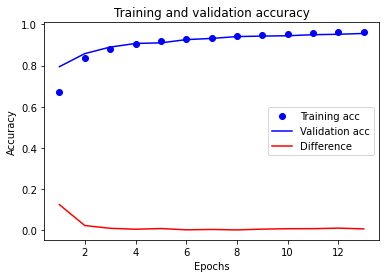

0.969% is correct with the train data
Counts: correct = 33920 total = 35000
0.957% is correct with the test data
Counts: correct = 28697 total = 30000
Confusion matrix, without normalization


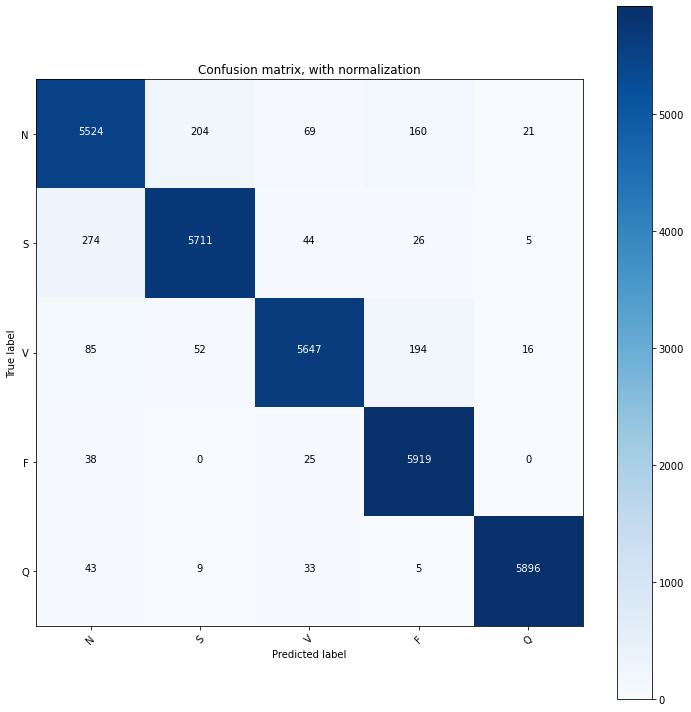

In [128]:
GenerateAndTrainModel(NN_data_train_u,NN_label_train_u,NN_val_data_train_u,NN_val_label_train_u,label_test_u,data_test_u,13)

In [102]:
#model.save('ECGModel_95%_upsample.h5')

In [129]:
label_test.shape

(1200, 5)

In [130]:
data_test.shape

(1200, 187, 1)